In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy
from collections import defaultdict
import importlib
import pprint

from interval import interval

import screed

import alignplot
importlib.reload(alignplot)

from alignplot import StackedDotPlot

import numpy as np

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

In [2]:
if 1:
    dotplot = StackedDotPlot('GCA_003222275.1',
                             ['GCA_003220225.1'],
                             'list.csv', './genomes', use_mashmap=True)

['./genomes/GCA_003222275.1_ASM322227v1_genomic.fna']
found queryfile for GCA_003222275.1: ./genomes/GCA_003222275.1_ASM322227v1_genomic.fna
found targetfile for GCA_003220225.1: ./genomes/GCA_003220225.1_ASM322022v1_genomic.fna


running mashmap...
running mashmap -q ./genomes/GCA_003222275.1_ASM322227v1_genomic.fna -r ./genomes/GCA_003220225.1_ASM322022v1_genomic.fna -o /var/folders/y6/s1r3q87933s6gjdrtmts1npc0000gq/T/tmpnahad70n/mashmap.out --pi 95
...done! reading output from /var/folders/y6/s1r3q87933s6gjdrtmts1npc0000gq/T/tmpnahad70n/mashmap.out.
shared w/Candidatus Rokubacteria bacterium: 435.6kb


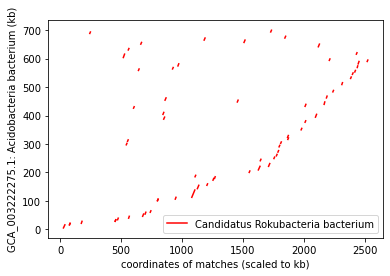

In [3]:
_ = dotplot()

In [4]:
class AlignmentDiagram:
    def __init__(self, dotplot):
        self.dotplot = dotplot
        
    def calculate(self, select_n=10, plot_all_contigs=False):
        dotplot = self.dotplot
        dotplot()

        regions = []
        for k, v in dotplot.results.items():
            regions.extend(v)

        queryfile = dotplot.queryfile

        # calculate and sort region summed kb in alignments over 95%            
        regions_by_query = alignplot.group_regions_by(regions, "query")
        regions_aligned_kb = alignplot.calc_regions_aligned_bp(
            regions_by_query, "query", filter_by=lambda r: r.pident >= 95
        )
        region_items = list(regions_aligned_kb.items())
        region_items.sort(key=lambda x: -x[1])
        
        if select_n:
            region_items = region_items[:select_n]

        query_sizes = alignplot.load_contig_sizes(dotplot.queryfile)

        target_sizes = {}
        for targetfile in dotplot.targetfiles:
            target_sizes.update(alignplot.load_contig_sizes(targetfile))


        query_list = []
        target_list = []
        align = []

        query_idx_d = {}
        target_idx_d = {}

        for name, aligned_kb in region_items:
            for alignment in regions_by_query[name]:
                a = alignment

                query_idx = query_idx_d.get(a.query)
                if query_idx is None:
                    query_idx_d[a.query] = len(query_list)
                    query_idx = len(query_list)
                    query_list.append(a.qsize)

                target_idx = target_idx_d.get(a.target)
                if target_idx is None:
                    target_idx_d[a.target] = len(target_list)
                    target_idx = len(target_list)
                    target_list.append(a.tsize)

                align.append((query_idx, a.qstart, a.qend,
                              target_idx, a.tstart, a.tend))

        if plot_all_contigs:
            remaining_query = set(query_sizes) - set(query_idx_d)
            remaining_target = set(target_sizes) - set(target_idx_d)

            for query in remaining_query:
                query_list.append(query_sizes[query])
            for target in remaining_target:
                target_list.append(target_sizes[target])
                
        self.from_contig_sizes = query_list
        self.to_contig_sizes = target_list
        self.alignments = align
        
    def plot(self, use_labels=True):
        from_contigs = self.from_contig_sizes
        to_contigs = self.to_contig_sizes
        alignments = self.alignments
        
        fig, ax = plt.subplots()
        patches = []

        from_sum = sum(from_contigs)
        to_sum = sum(to_contigs)
        
        from_bases = [0]
        sofar = 0
        for i in from_contigs:
            sofar += i
            from_bases.append(sofar)
        
        to_bases = [0]
        sofar = 0
        for i in to_contigs:
            sofar += i
            to_bases.append(sofar)

        for (from_i, qstart, qend, to_i, tstart, tend) in alignments:
            assert qstart <= from_contigs[from_i]
            assert qstart >= 0
            assert qend <= from_contigs[from_i]
            assert qend >= 0

            assert tstart <= to_contigs[to_i]
            assert tstart >= 0
            assert tend <= to_contigs[to_i]
            assert tend >= 0

            upper_left = (0, 1 - (from_bases[from_i] + qstart) / from_sum)
            upper_right = (0, 1 - (from_bases[from_i] + qend) / from_sum)
            bottom_right = (1, 1 - (to_bases[to_i] + tend) / to_sum)
            bottom_left = (1, 1 - (to_bases[to_i] + tstart) / to_sum)
 
            polygon = Polygon((upper_left, upper_right, bottom_right, bottom_left), True)
            patches.append(polygon)

        patches.append(polygon)

        p = PatchCollection(patches, cmap=matplotlib.cm.jet, alpha=0.4)

        colors = 100*np.random.rand(len(patches))
        p.set_array(np.array(colors))

        ax.add_collection(p)

        ax.set_ylabel('contaminated genome contigs')
        from_yticks = [ 1 - i / from_sum for i in from_bases]
        ax.set_yticks(from_yticks)
        if use_labels:
            ax.set_yticklabels([ f"{i:.0f}kb" for i in from_bases ])
        else:
            ax.set_yticklabels([])
        
        secax = ax.secondary_yaxis('right')       
        secax.set_ylabel('source genome contigs')
        to_yticks = [ 1 - i/to_sum for i in to_bases ]
        secax.set_yticks(to_yticks)
        if use_labels:
            secax.set_yticklabels([ f"{i:.0f}kb" for i in to_bases ])
        else:
            secax.set_yticklabels([])

        #plt.tick_params(axis='y', which='both', left=False, right=False)
        ax.set_xticks([])
        ax.set_xticklabels([])
        
        return plt.gcf()

running mashmap...
running mashmap -q ./genomes/GCA_003222275.1_ASM322227v1_genomic.fna -r ./genomes/GCA_003220225.1_ASM322022v1_genomic.fna -o /var/folders/y6/s1r3q87933s6gjdrtmts1npc0000gq/T/tmp7nd420bs/mashmap.out --pi 95
...done! reading output from /var/folders/y6/s1r3q87933s6gjdrtmts1npc0000gq/T/tmp7nd420bs/mashmap.out.
shared w/Candidatus Rokubacteria bacterium: 435.6kb


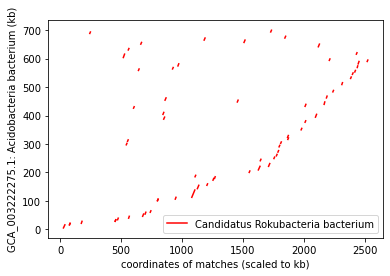

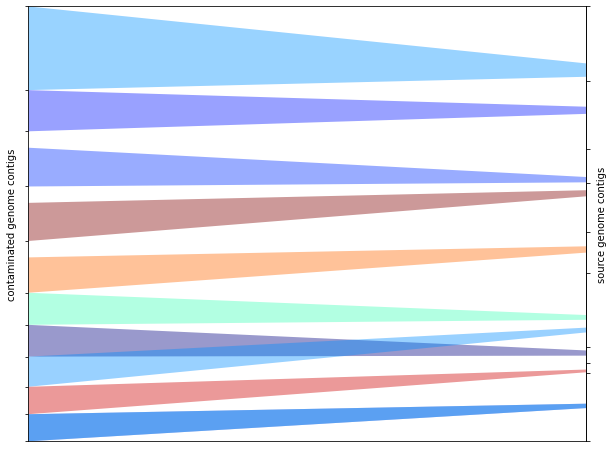

In [5]:
alignme = AlignmentDiagram(dotplot)
alignme.calculate()
fig = alignme.plot(use_labels=False)
fig.set_size_inches(10,8)
plt.savefig('/tmp/foo.png')

running mashmap...
running mashmap -q ./genomes/GCA_003222275.1_ASM322227v1_genomic.fna -r ./genomes/GCA_003220225.1_ASM322022v1_genomic.fna -o /var/folders/y6/s1r3q87933s6gjdrtmts1npc0000gq/T/tmpsjrnrnra/mashmap.out --pi 95
...done! reading output from /var/folders/y6/s1r3q87933s6gjdrtmts1npc0000gq/T/tmpsjrnrnra/mashmap.out.
shared w/Candidatus Rokubacteria bacterium: 435.6kb


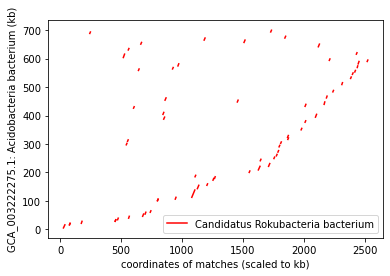

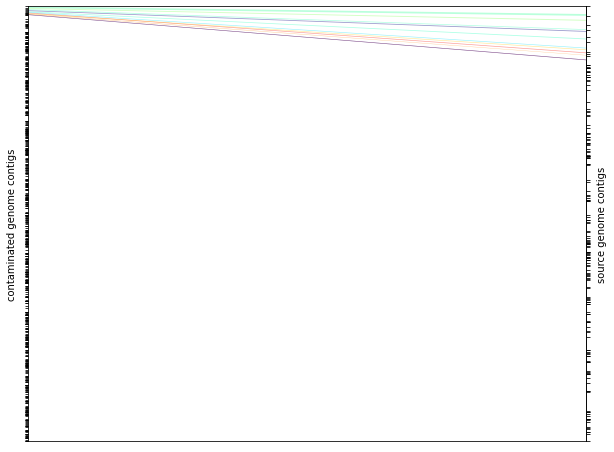

In [6]:
alignme.calculate(plot_all_contigs=True)
fig = alignme.plot(use_labels=False)
fig.set_size_inches(10,8)
plt.savefig('/tmp/foo2.png')